# UFC Fight Predictions - Clean Interface

Simple, focused notebook for predicting UFC fight outcomes using the latest trained models.

**Features:**
- Automatic latest model loading
- Single fight predictions
- Full fight card analysis
- Clean, professional output

In [1]:
# Essential imports
import pandas as pd
import numpy as np
import joblib
import json
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
sys.path.append('..')
print("✅ Imports loaded successfully")

✅ Imports loaded successfully


In [2]:
# Load latest trained models and data
def load_latest_models():
    """Auto-detect and load the latest trained models."""
    model_dir = Path('./model')
    
    # Find latest training directory
    training_dirs = [d for d in model_dir.iterdir() 
                    if d.is_dir() and d.name.startswith('training_')]
    
    if training_dirs:
        latest_dir = max(training_dirs, key=lambda x: x.stat().st_mtime)
        timestamp = latest_dir.name.split('_', 1)[1]
        
        # Load from latest training directory
        winner_model_path = latest_dir / f'ufc_winner_model_tuned_{timestamp}.joblib'
        method_model_path = latest_dir / f'ufc_method_model_{timestamp}.joblib'
        winner_cols_path = latest_dir / f'winner_model_columns_{timestamp}.json'
        method_cols_path = latest_dir / f'method_model_columns_{timestamp}.json'
        fighters_data_path = latest_dir / f'ufc_fighters_engineered_{timestamp}.csv'
        version = timestamp
    else:
        # Fallback to standard locations
        winner_model_path = model_dir / 'ufc_random_forest_model_tuned.joblib'
        method_model_path = model_dir / 'ufc_multiclass_model.joblib'
        winner_cols_path = model_dir / 'winner_model_columns.json'
        method_cols_path = model_dir / 'method_model_columns.json'
        fighters_data_path = model_dir / 'ufc_fighters_engineered_corrected.csv'
        version = 'standard'
    
    # Load all components
    try:
        fighters_df = pd.read_csv(fighters_data_path)
        
        with open(winner_cols_path, 'r') as f:
            winner_cols = json.load(f)
        with open(method_cols_path, 'r') as f:
            method_cols = json.load(f)
        
        winner_model = joblib.load(winner_model_path)
        method_model = joblib.load(method_model_path)
        
        return {
            'fighters_df': fighters_df,
            'winner_cols': winner_cols,
            'method_cols': method_cols,
            'winner_model': winner_model,
            'method_model': method_model,
            'version': version,
            'fighter_count': len(fighters_df)
        }
    except Exception as e:
        print(f"❌ Error loading models: {e}")
        return None

# Load models
model_data = load_latest_models()

if model_data:
    print(f"✅ Models loaded successfully")
    print(f"   Version: {model_data['version']}")
    print(f"   Fighters in database: {model_data['fighter_count']:,}")
    print(f"   Winner model features: {len(model_data['winner_cols'])}")
else:
    print("❌ Failed to load models. Check if models exist in ./model/ directory.")

✅ Models loaded successfully
   Version: 2025-07-30_17-06
   Fighters in database: 4,378
   Winner model features: 70


In [3]:
# Clean prediction function
def predict_fight(fighter1, fighter2, show_details=True):
    """Predict UFC fight outcome with clean output."""
    
    if not model_data:
        return {"error": "Models not loaded"}
    
    # Import prediction function
    try:
        from ufc_predictor.core.prediction import predict_fight_symmetrical
    except ImportError:
        return {"error": "Could not import prediction function"}
    
    # Make prediction
    result = predict_fight_symmetrical(
        fighter1, fighter2,
        model_data['fighters_df'],
        model_data['winner_cols'],
        model_data['method_cols'],
        model_data['winner_model'],
        model_data['method_model']
    )
    
    # Handle errors
    if 'error' in result:
        if show_details:
            print(f"❌ {result['error']}")
        return result
    
    # Display results
    if show_details:
        print(f"🥊 {result['fight']}")
        print(f"   Winner: {result['predicted_winner']} ({result['winner_confidence']})")
        print(f"   Method: {result['predicted_method']}")
        print(f"   Method probabilities:")
        for method, prob in result['method_probabilities'].items():
            print(f"      {method}: {prob}")
    
    return result

print("✅ Prediction function ready")

✅ Prediction function ready


In [4]:
# Single Fight Prediction
# Simply change the fighter names below to predict any fight

fighter_a = "Khamzat Chimaev"
fighter_b = "dricus du plessis"

prediction = predict_fight(fighter_a, fighter_b)

# You can also predict other fights by changing the names:
# prediction = predict_fight("Islam Makhachev", "Charles Oliveira")
# prediction = predict_fight("Alex Pereira", "Israel Adesanya")

🥊 Khamzat Chimaev vs dricus du plessis
   Winner: Khamzat Chimaev (54.46%)
   Method: KO/TKO
   Method probabilities:
      Decision: 6.94%
      KO/TKO: 52.14%
      Submission: 40.92%


In [11]:
# Multi-Fight Card Analysis
def predict_fight_card(fight_list, show_summary=True):
    """Predict multiple fights with clean summary."""
    
    results = []
    
    print(f"🏆 UFC FIGHT CARD PREDICTIONS\n{'-'*50}")
    
    for i, fight in enumerate(fight_list, 1):
        # Handle different input formats
        if isinstance(fight, tuple):
            f1, f2 = fight
        elif ' vs ' in fight:
            f1, f2 = fight.split(' vs ')
        elif ' vs. ' in fight:
            f1, f2 = fight.split(' vs. ')
        else:
            print(f"❌ Invalid fight format: {fight}")
            continue
        
        f1, f2 = f1.strip(), f2.strip()
        
        print(f"\nFight {i}: {f1} vs {f2}")
        result = predict_fight(f1, f2, show_details=False)
        
        if 'error' not in result:
            print(f"   → {result['predicted_winner']} ({result['winner_confidence']})")
            print(f"   → Method: {result['predicted_method']}")
            results.append(result)
        else:
            print(f"   → {result['error']}")
    
    # Summary
    if show_summary and results:
        print(f"\n📊 CARD SUMMARY\n{'-'*20}")
        
        # Method distribution
        methods = [r['predicted_method'] for r in results]
        method_counts = pd.Series(methods).value_counts()
        
        print("Predicted methods:")
        for method, count in method_counts.items():
            print(f"   {method}: {count} fights")
    
    return results

print("✅ Fight card function ready")

✅ Fight card function ready


In [12]:
# Example Fight Card
# Edit this list to predict any upcoming UFC card

upcoming_card = [
    "Jon Jones vs Stipe Miocic",
    "Islam Makhachev vs Charles Oliveira", 
    "Alex Pereira vs Israel Adesanya",
    "Sean O'Malley vs Aljamain Sterling",
    "Colby Covington vs Leon Edwards"
]

card_results = predict_fight_card(upcoming_card)

# Alternative format - you can also use tuples:
# card_as_tuples = [
#     ("Fighter A", "Fighter B"),
#     ("Fighter C", "Fighter D")
# ]
# results = predict_fight_card(card_as_tuples)

🏆 UFC FIGHT CARD PREDICTIONS
--------------------------------------------------

Fight 1: Jon Jones vs Stipe Miocic
   → Jon Jones (96.21%)
   → Method: KO/TKO

Fight 2: Islam Makhachev vs Charles Oliveira
   → Islam Makhachev (95.03%)
   → Method: Submission

Fight 3: Alex Pereira vs Israel Adesanya
   → Alex Pereira (63.38%)
   → Method: KO/TKO

Fight 4: Sean O'Malley vs Aljamain Sterling
   → Sean O'Malley (89.69%)
   → Method: KO/TKO

Fight 5: Colby Covington vs Leon Edwards
   → Leon Edwards (79.43%)
   → Method: KO/TKO

📊 CARD SUMMARY
--------------------
Predicted methods:
   KO/TKO: 4 fights
   Submission: 1 fights


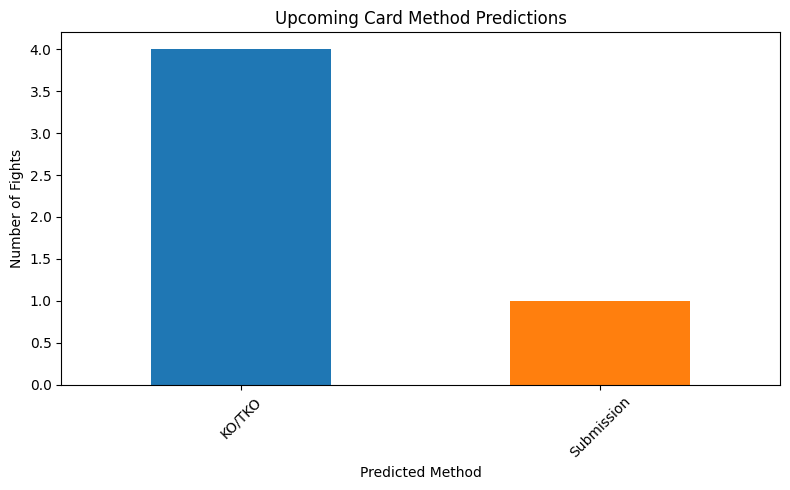


Method breakdown: {'KO/TKO': np.int64(4), 'Submission': np.int64(1)}


In [13]:
# Optional: Basic Visualization
def plot_fight_methods(results, title="Fight Card Method Predictions"):
    """Simple bar chart of predicted methods."""
    
    if not results:
        print("No results to plot")
        return
    
    # Count predicted methods
    methods = [r['predicted_method'] for r in results if 'predicted_method' in r]
    method_counts = pd.Series(methods).value_counts()
    
    # Create simple bar plot
    plt.figure(figsize=(8, 5))
    method_counts.plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    plt.title(title)
    plt.xlabel('Predicted Method')
    plt.ylabel('Number of Fights') 
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return method_counts

# Plot the results from the previous card (if any)
if 'card_results' in locals() and card_results:
    method_distribution = plot_fight_methods(card_results, "Upcoming Card Method Predictions")
    print(f"\nMethod breakdown: {dict(method_distribution)}")
else:
    print("No card results to visualize. Run the fight card prediction first.")

In [14]:
# Optional: Fighter Search Helper
def search_fighters(search_term, limit=10):
    """Find fighters in database by name."""
    
    if not model_data:
        print("Models not loaded")
        return []
    
    # Search for fighters containing the term
    fighters = model_data['fighters_df']['Name'].dropna()
    matches = fighters[fighters.str.contains(search_term, case=False, na=False)]
    
    results = matches.head(limit).tolist()
    
    if results:
        print(f"Found {len(results)} fighters matching '{search_term}':")
        for i, fighter in enumerate(results, 1):
            print(f"   {i}. {fighter}")
    else:
        print(f"No fighters found matching '{search_term}'")
    
    return results

# Example searches - uncomment to use:
# search_fighters("Jones")
# search_fighters("Silva")
# search_fighters("Mac")  # Will find McGregor, MacDonald, etc.

print("\n✅ All functions ready! You can now:")
print("   • Modify fighter names in the single fight cell")
print("   • Edit the upcoming_card list for multi-fight predictions")
print("   • Use search_fighters('name') to find exact fighter names")
print("   • Run plot_fight_methods(results) for visualizations")


✅ All functions ready! You can now:
   • Modify fighter names in the single fight cell
   • Edit the upcoming_card list for multi-fight predictions
   • Use search_fighters('name') to find exact fighter names
   • Run plot_fight_methods(results) for visualizations
